# Setting things up

In [1]:
import numpy as np
import time
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.decomposition import PCA
from tqdm import tqdm

random_state=42
np.random.seed(random_state)

In [2]:
alpha=.01 #Significance level
iterations=500 #MC simulations to calculate type-1 error and power
n_vals=100 #Number of training sets
dz=300 #Z dim
m=250 #Training set size
n=250 #Test set size
frac=.1
pca_d=10

class Lasso():
    def __init__(self, random_state):
        self.random_state = random_state
    def fit(self, X, Y):
        self.model = LassoCV(cv=5, n_alphas=100, random_state=self.random_state).fit(X, Y.squeeze())
    def predict(self, X):
        return self.model.predict(X).reshape((-1,1))

class PCR():
    def __init__(self, d):
        self.d=d
    def fit(self, X, Y):
        self.pca = PCA(n_components=self.d)
        self.model = LinearRegression().fit(self.pca.fit_transform(X), Y.squeeze())
    def predict(self, X):
        return self.model.predict(self.pca.transform(X)).reshape((-1,1))

def get_pval_stfr(X, Z, Y, model_1, model_2):
    n = X.shape[0]
    loss1 = (model_1.predict(np.hstack((X,Z))) - Y)**2
    loss2 = (model_2.predict(Z) - Y)**2
    T = loss2-loss1
    pval = 1 - scipy.stats.norm.cdf(np.sqrt(n)*np.mean(T)/np.std(T))
    return pval

def exp_linear_model(rs):
    
    #time.sleep(rs**.5) 
    #print("*",rs,"*")
    
    total = 3*(iterations+1)
    pvals = []

    #Generative params
    beta = np.vstack((np.ones(int(frac*dz)).reshape((-1,1)), np.zeros(dz-int(frac*dz)).reshape((-1,1))))

    #Training data
    Z_train = np.random.normal(0, 1, m*dz).reshape((m,dz))
    X_train = (Z_train@beta) 
    X_train += np.random.normal(0, 1, X_train.shape)
    Y_train = (Z_train@beta)  
    Y_train += np.random.normal(0, 1, Y_train.shape)

    #Models
    lasso_1 = Lasso(0)
    lasso_1.fit(np.hstack((Z_train, X_train)), Y_train)
    lasso_2 = Lasso(0)
    lasso_2.fit(Z_train, Y_train)
    pcr_1 = PCR(pca_d)
    pcr_1.fit(np.hstack((Z_train, X_train)), Y_train)
    pcr_2 = PCR(pca_d)
    pcr_2.fit(Z_train, Y_train)

    for it in range(iterations):

        Z_test = np.random.normal(0, 1, m*dz).reshape((m,dz))
        X_test = (Z_test@beta) 
        X_test += np.random.normal(0, 1, X_test.shape)
        Y_test = (Z_test@beta)
        Y_test += np.random.normal(0, 1, Y_test.shape)

        #Tests
        pvals.append([get_pval_stfr(X_test, Z_test, Y_test, lasso_1, lasso_2),
                      get_pval_stfr(X_test, Z_test, Y_test, pcr_1, pcr_2)])

    return pvals

In [3]:
pvals = [exp_linear_model(j) for j in tqdm(range(n_vals))]
pvals = np.array(pvals)

100%|█████████████████████████████████████████| 100/100 [41:47<00:00, 25.08s/it]


In [4]:
pvals.shape

(100, 500, 2)

In [5]:
error = np.mean(pvals<alpha, axis=1)

In [6]:
error.shape

(100, 2)

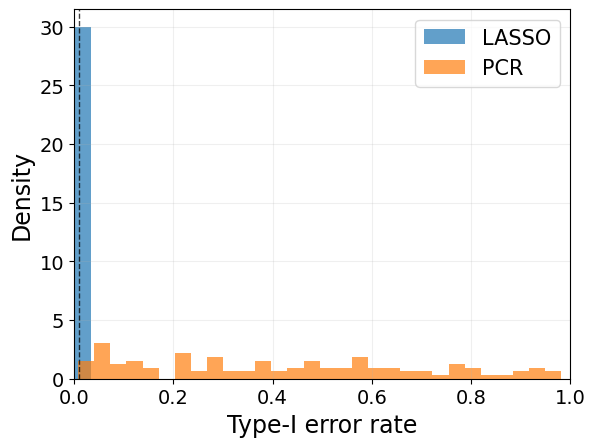

In [7]:
plt.hist(error[:,0], alpha=.7, bins=30, density=True, label='LASSO')
plt.hist(error[:,1], alpha=.7, bins=30, density=True, label='PCR')
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Type-I error rate", size=17)
plt.ylabel("Density", size=17)
plt.axvline(x=alpha, color='black', linestyle='--', lw=1, alpha=.75)
plt.grid(alpha=.2)
plt.legend(framealpha=0.75, prop={'size': 15}, ncol=1) 
plt.savefig('plots/linear_model_exp2.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()